# Modeling and Evaluation
## Diabetes Risk & Insulin Management System

This notebook covers:
- Model training (Multiple algorithms)
- Model evaluation and comparison
- Model selection
- Model saving
- Performance visualization


In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import pickle
from datetime import datetime

# Add parent directory to path
sys.path.insert(0, str(Path().resolve().parent))

from src.utils.config import FINAL_FEATURES, TARGET, MODELS_DIR, PATIENT_ID_COL
from src.cds import HybridCDS, LightweightMLModel

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available")

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available")

warnings.filterwarnings('ignore')
%matplotlib inline

print("Libraries imported successfully!")


LightGBM not available
Libraries imported successfully!


## 1. Load Processed Data


In [11]:
# Load processed data
df = pd.read_csv(FINAL_FEATURES)

print(f"Data shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Prepare features and target
exclude_cols = [TARGET, PATIENT_ID_COL, 'Timestamp_ts', 'timestamp_sorted']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].copy()
y = df[TARGET].copy()

# Remove any remaining missing values
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\nFeatures: {len(feature_cols)}")
print(f"Samples: {len(X)}")
print(f"Target: {TARGET}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

X.head()


Data shape: (535, 22)

Columns: ['Patient_ID', 'Glucose_std_3', 'Step_intensity', 'Activity_Level', 'time_delta_hours', 'Glucose_Level', 'Sleep_efficiency', 'Sleep_Duration', 'Predicted_Progression', 'Medication_Intake', 'BMI', 'Glucose_to_HbA1c', 'Calories_Burned', 'Stress_Level', 'Diet_Quality_Score', 'Timestamp_dow', 'Timestamp_cos_hour', 'HbA1c', 'Timestamp_month', 'Timestamp_sin_hour', 'BP_ratio', 'Insulin_Dose']

Features: 20
Samples: 436
Target: Insulin_Dose

Train set: 348 samples
Test set: 88 samples


,Glucose_std_3,Step_intensity,Activity_Level,time_delta_hours,Glucose_Level,Sleep_efficiency,Sleep_Duration,Predicted_Progression,Medication_Intake,BMI,Glucose_to_HbA1c,Calories_Burned,Stress_Level,Diet_Quality_Score,Timestamp_dow,Timestamp_cos_hour,HbA1c,Timestamp_month,Timestamp_sin_hour,BP_ratio
1,2.018666,-0.383665,1.260446,0.306325,1.275904,-1.368356,-1.368356,-1.021552,1.059724,0.998452,0.258013,0.661056,1.603668,1.506909,0.011143,-1.187385,1.151150,-0.813321,-0.682853,-1.126248
2,1.162718,-0.604328,1.571058,-0.004792,1.021735,-0.607152,-0.607152,1.479731,-0.943642,0.004043,0.242862,1.034490,-0.155894,1.506909,1.004726,1.420754,0.836103,-0.813321,0.033410,-0.611039
3,0.484124,-0.802284,1.260446,0.692109,-0.777517,-0.261150,-0.261150,-1.021552,1.059724,-0.716904,-0.602829,-0.930628,0.196018,-1.308268,-1.479232,1.011378,-0.214056,-0.813321,-0.979540,0.098252
4,0.241741,-0.663079,1.571058,0.692109,-0.650433,1.745660,1.745660,-1.021552,1.059724,-0.542883,-0.646938,0.124373,0.196018,0.803115,1.004726,-0.338694,0.100992,1.229527,1.417125,0.693689
6,-0.328112,1.262576,-1.224450,0.692109,-1.021654,0.154052,0.154052,1.479731,1.059724,-1.263830,-1.434999,-0.473529,-1.211631,-0.604474,-1.479232,-1.327015,1.571213,-0.813321,0.404176,-0.085571


## 2. Train Multiple Models


In [12]:
# Train multiple models
print("=" * 60)
print("TRAINING MULTIPLE MODELS")
print("=" * 60)

models = {}
results = {}

# 1. LightGBM
if LIGHTGBM_AVAILABLE:
    print("\nTraining LightGBM...")
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.05,
        random_state=42,
        verbosity=-1
    )
    lgb_model.fit(X_train, y_train)
    models['LightGBM'] = lgb_model
    print("LightGBM trained!")

# 2. XGBoost
if XGBOOST_AVAILABLE:
    print("\nTraining XGBoost...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.05,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    models['XGBoost'] = xgb_model
    print("XGBoost trained!")

# 3. Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model
print("Random Forest trained!")

# 4. Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
models['Gradient Boosting'] = gb_model
print("Gradient Boosting trained!")

# 5. Ridge Regression
print("\nTraining Ridge Regression...")
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
models['Ridge'] = ridge_model
print("Ridge Regression trained!")

print(f"\nTotal models trained: {len(models)}")


TRAINING MULTIPLE MODELS

Training XGBoost...


XGBoost trained!

Training Random Forest...
Random Forest trained!

Training Gradient Boosting...
Gradient Boosting trained!

Training Ridge Regression...
Ridge Regression trained!

Total models trained: 4


## 3. Evaluate Models


MODEL EVALUATION

Model Performance Comparison:
            Model  Train RMSE  Train MAE  Train R²  Test RMSE  Test MAE   Test R²
            Ridge    3.268972   2.809688  0.042737   3.406095  2.968022 -0.027845
    Random Forest    1.452811   1.232097  0.810928   3.466750  2.936335 -0.064778
Gradient Boosting    0.469470   0.371776  0.980256   3.599601  3.012696 -0.147950
          XGBoost    0.564713   0.429045  0.971433   3.637244  3.101853 -0.172085


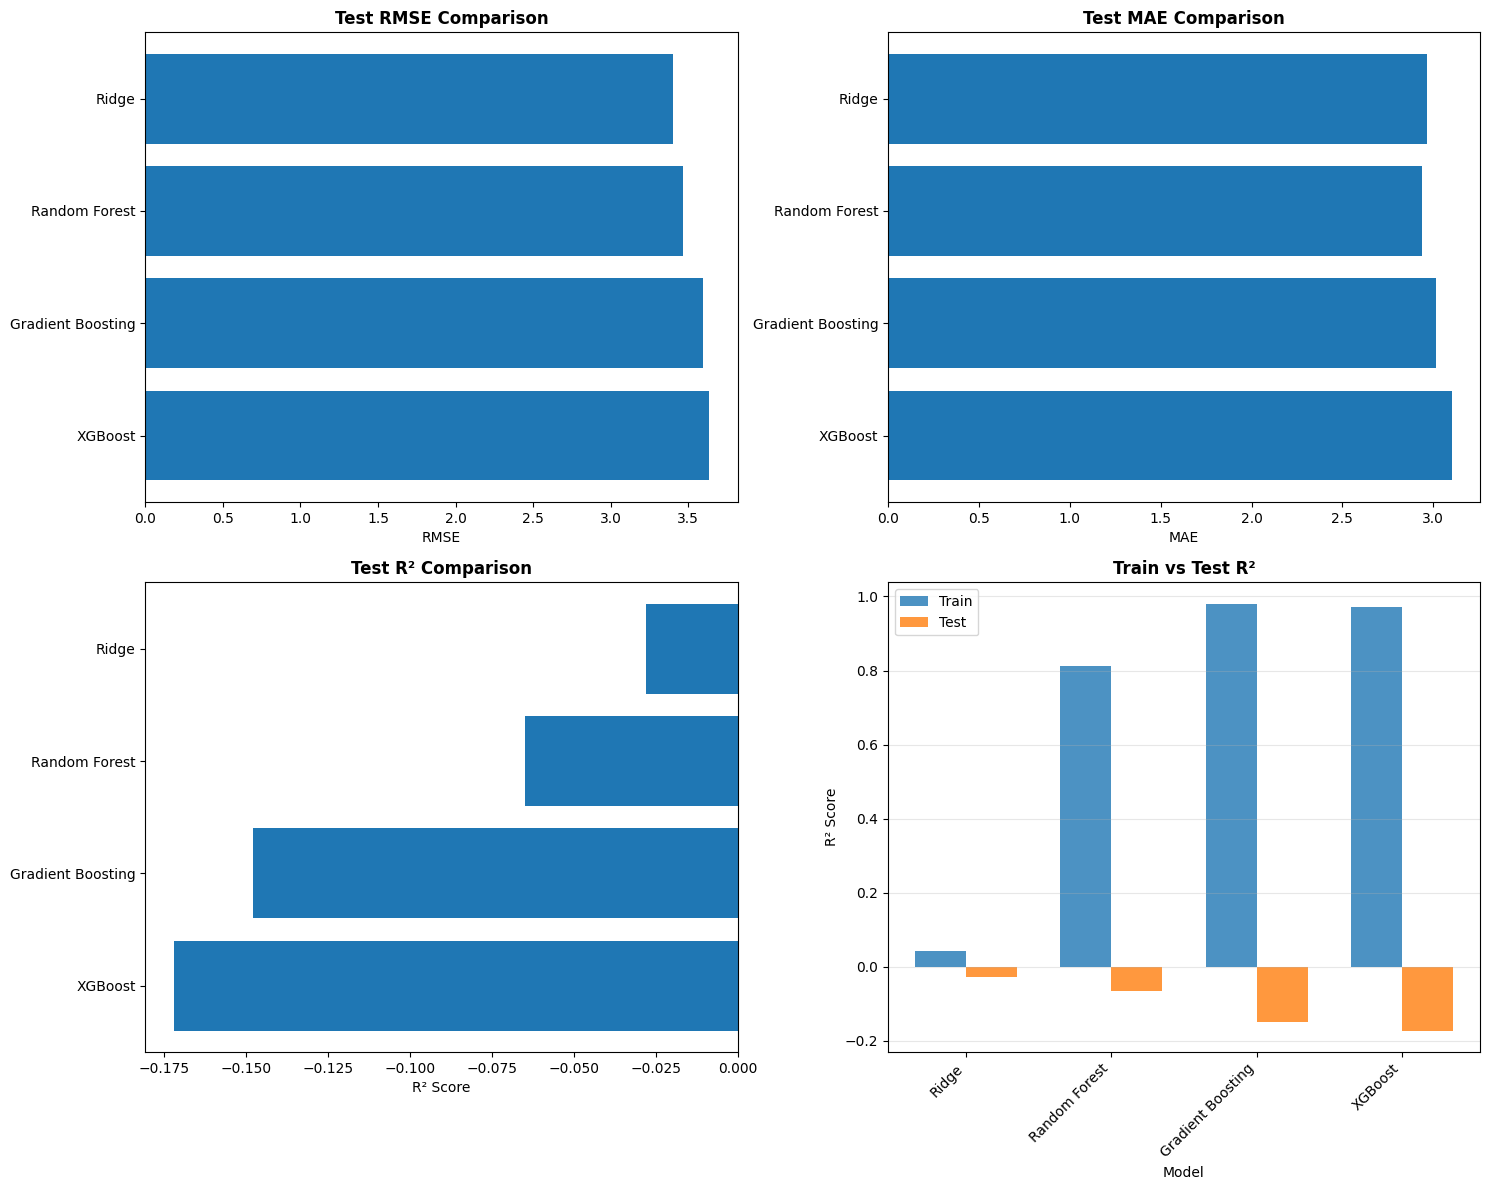

In [13]:
# Evaluate all models
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    """Evaluate a model and return metrics"""
    # Train predictions
    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    return {
        'Model': name,
        'Train RMSE': train_rmse,
        'Train MAE': train_mae,
        'Train R²': train_r2,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'Test R²': test_r2
    }

# Evaluate all models
evaluation_results = []
for name, model in models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    evaluation_results.append(metrics)
    results[name] = {
        'model': model,
        'metrics': metrics,
        'predictions': {
            'train': model.predict(X_train),
            'test': model.predict(X_test)
        }
    }

# Create results dataframe
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.sort_values('Test R²', ascending=False)

print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RMSE comparison
axes[0, 0].barh(results_df['Model'], results_df['Test RMSE'])
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Test RMSE Comparison', fontweight='bold')
axes[0, 0].invert_yaxis()

# MAE comparison
axes[0, 1].barh(results_df['Model'], results_df['Test MAE'])
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Test MAE Comparison', fontweight='bold')
axes[0, 1].invert_yaxis()

# R² comparison
axes[1, 0].barh(results_df['Model'], results_df['Test R²'])
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Test R² Comparison', fontweight='bold')
axes[1, 0].invert_yaxis()

# Train vs Test R²
x_pos = np.arange(len(results_df))
width = 0.35
axes[1, 1].bar(x_pos - width/2, results_df['Train R²'], width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, results_df['Test R²'], width, label='Test', alpha=0.8)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Train vs Test R²', fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


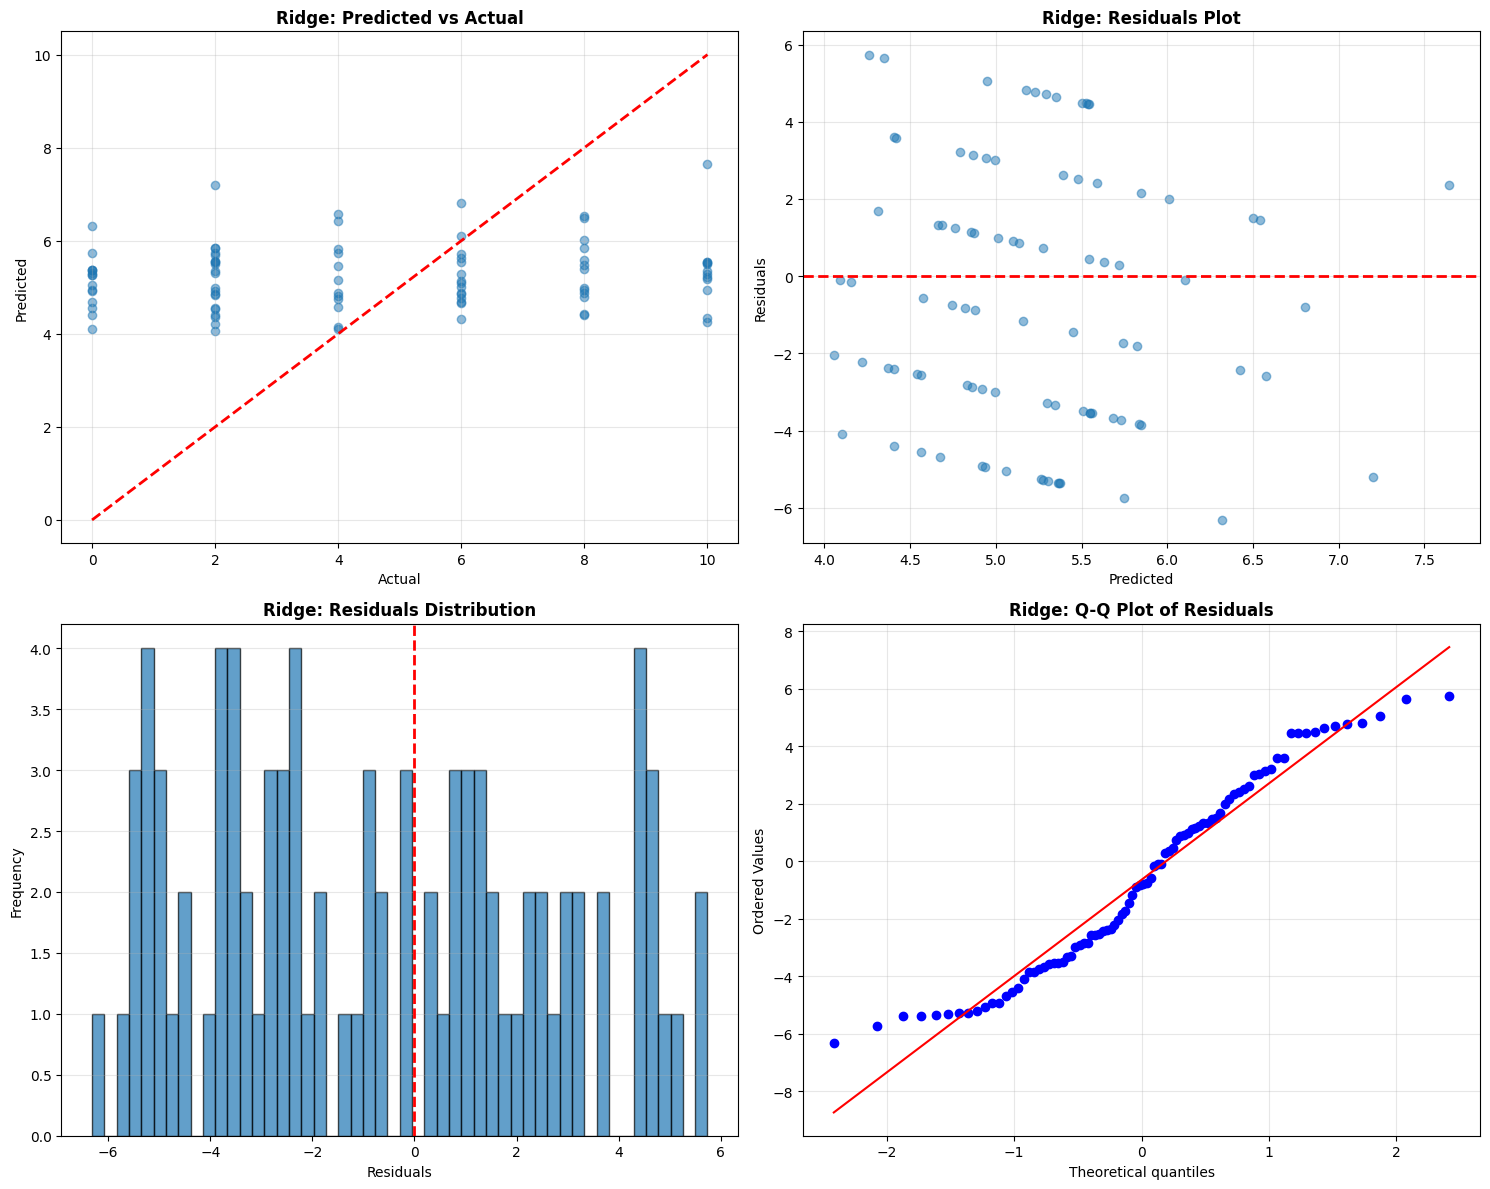


Best Model: Ridge
Test R²: -0.0278
Test RMSE: 3.4061
Test MAE: 2.9680


In [14]:
# Visualize predictions vs actual
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
y_test_pred = results[best_model_name]['predictions']['test']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot: Predicted vs Actual
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title(f'{best_model_name}: Predicted vs Actual', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title(f'{best_model_name}: Residuals Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Distribution of residuals
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'{best_model_name}: Residuals Distribution', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Q-Q plot of residuals
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title(f'{best_model_name}: Q-Q Plot of Residuals', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {results_df.iloc[0]['Test R²']:.4f}")
print(f"Test RMSE: {results_df.iloc[0]['Test RMSE']:.4f}")
print(f"Test MAE: {results_df.iloc[0]['Test MAE']:.4f}")


## 5. Feature Importance (Best Model)


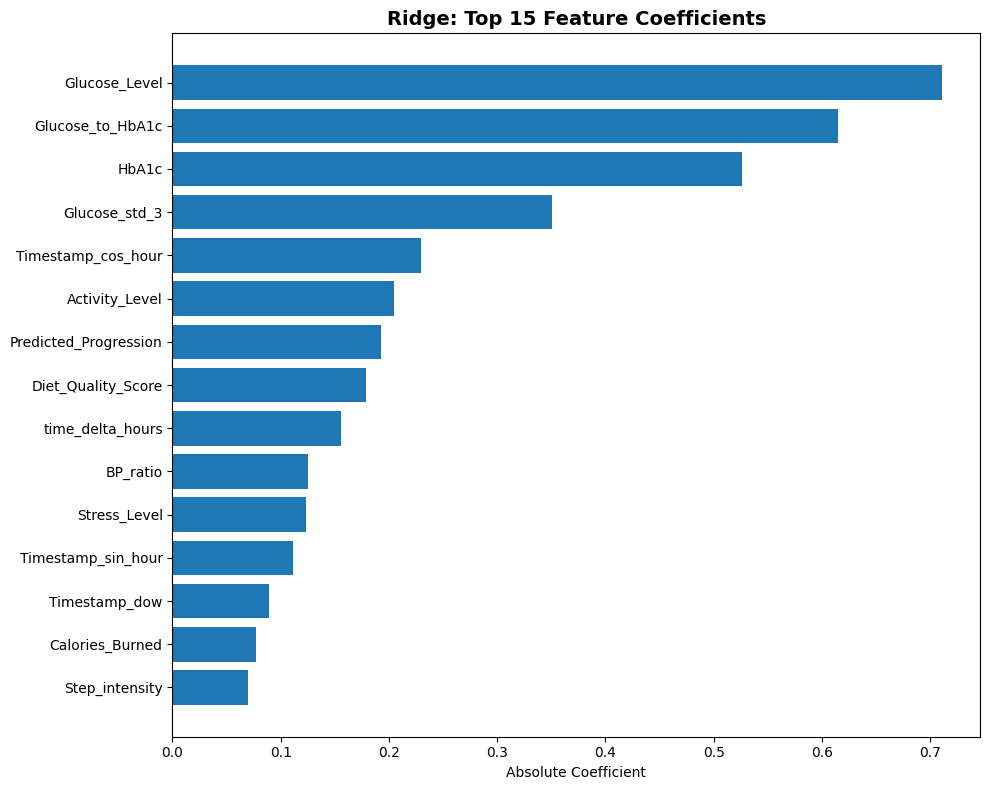


Top 10 Most Important Features (by coefficient):
              Feature  Coefficient
        Glucose_Level     0.710602
     Glucose_to_HbA1c     0.614690
                HbA1c     0.526208
        Glucose_std_3     0.350522
   Timestamp_cos_hour     0.229539
       Activity_Level     0.205056
Predicted_Progression     0.192568
   Diet_Quality_Score     0.179200
     time_delta_hours     0.155456
             BP_ratio     0.125191


In [15]:
# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15 features
    top_features = feature_importance.head(15)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'{best_model_name}: Top 15 Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
elif hasattr(best_model, 'coef_'):
    # For linear models
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values('Coefficient', ascending=False)
    
    top_features = feature_importance.head(15)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['Coefficient'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Absolute Coefficient')
    plt.title(f'{best_model_name}: Top 15 Feature Coefficients', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features (by coefficient):")
    print(feature_importance.head(10).to_string(index=False))
else:
    print("Feature importance not available for this model type")


## 6. Train Hybrid CDS System


In [16]:
# Train the complete Hybrid CDS system
print("=" * 60)
print("TRAINING HYBRID CDS SYSTEM")
print("=" * 60)

# Use the best model type
best_model_type = 'lightgbm' if 'LightGBM' in best_model_name else \
                  'xgboost' if 'XGBoost' in best_model_name else \
                  'rf' if 'Random Forest' in best_model_name else 'auto'

# Create CDS system
ml_model = LightweightMLModel(model_type=best_model_type)
cds = HybridCDS(ml_model=ml_model)

# Train
print(f"\nTraining CDS with {best_model_type} model...")
cds_metrics = cds.train_ml_model(X_train, y_train, training_data_for_explainer=X_train)

print("\nCDS Training Metrics:")
for key, value in cds_metrics.items():
    print(f"  {key}: {value}")

# Evaluate CDS
y_test_pred_cds = cds.ml_model.predict(X_test)
cds_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_cds))
cds_test_mae = mean_absolute_error(y_test, y_test_pred_cds)
cds_test_r2 = r2_score(y_test, y_test_pred_cds)

print(f"\nCDS Test Performance:")
print(f"  RMSE: {cds_test_rmse:.4f}")
print(f"  MAE: {cds_test_mae:.4f}")
print(f"  R²: {cds_test_r2:.4f}")


TRAINING HYBRID CDS SYSTEM

Training CDS with auto model...
Using Random Forest (fallback).

CDS Training Metrics:
  train_rmse: 1.3535810811084248
  train_mae: 1.1283954829027942
  train_r2: 0.8252976713035483
  val_rmse: 3.753439591948916
  val_mae: 3.2258629986323855
  val_r2: -0.02113355681627227
  model_type: RandomForestRegressor

CDS Test Performance:
  RMSE: 3.4843
  MAE: 2.9518
  R²: -0.0756


## 7. Save Models


In [17]:
# Save all models
print("=" * 60)
print("SAVING MODELS")
print("=" * 60)

MODELS_DIR.mkdir(parents=True, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save individual models
for name, model in models.items():
    model_path = MODELS_DIR / f"{name.lower().replace(' ', '_')}_model.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump({
            'model': model,
            'feature_names': feature_cols,
            'target': TARGET,
            'metrics': results[name]['metrics'],
            'timestamp': timestamp
        }, f)
    print(f"Saved: {model_path}")

# Save best model separately
best_model_path = MODELS_DIR / "best_model.pkl"
with open(best_model_path, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'model_name': best_model_name,
        'feature_names': feature_cols,
        'target': TARGET,
        'metrics': results[best_model_name]['metrics'],
        'timestamp': timestamp
    }, f)
print(f"\nBest model saved: {best_model_path}")

# Save CDS system
cds_path = MODELS_DIR / "cds_model.pkl"
cds_without_explainer = HybridCDS(
    ml_model=cds.ml_model,
    rule_engine=cds.rule_engine,
    explainer=None,
    rule_override_threshold=cds.rule_override_threshold,
    ml_weight=cds.ml_weight,
    rule_weight=cds.rule_weight
)
with open(cds_path, 'wb') as f:
    pickle.dump({
        'cds': cds_without_explainer,
        'feature_names': feature_cols,
        'target': TARGET,
        'metrics': cds_metrics,
        'test_metrics': {
            'rmse': cds_test_rmse,
            'mae': cds_test_mae,
            'r2': cds_test_r2
        },
        'timestamp': timestamp
    }, f)
print(f"CDS system saved: {cds_path}")

# Save evaluation results
results_path = MODELS_DIR / "evaluation_results.csv"
results_df.to_csv(results_path, index=False)
print(f"Evaluation results saved: {results_path}")

print("\n" + "=" * 60)
print("All models saved successfully!")
print("=" * 60)


SAVING MODELS
Saved: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\xgboost_model.pkl
Saved: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\random_forest_model.pkl
Saved: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\gradient_boosting_model.pkl
Saved: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\ridge_model.pkl

Best model saved: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\best_model.pkl
CDS system saved: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\cds_model.pkl
Evaluation results saved: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\evaluation_results.csv

All models saved successfully!


## 8. Summary and Next Steps


In [18]:
# Final summary
print("=" * 60)
print("MODELING AND EVALUATION SUMMARY")
print("=" * 60)

print(f"\n1. Models Trained: {len(models)}")
print(f"   - {', '.join(models.keys())}")

print(f"\n2. Best Model: {best_model_name}")
print(f"   - Test R²: {results_df.iloc[0]['Test R²']:.4f}")
print(f"   - Test RMSE: {results_df.iloc[0]['Test RMSE']:.4f}")
print(f"   - Test MAE: {results_df.iloc[0]['Test MAE']:.4f}")

print(f"\n3. Hybrid CDS System:")
print(f"   - Test R²: {cds_test_r2:.4f}")
print(f"   - Test RMSE: {cds_test_rmse:.4f}")
print(f"   - Test MAE: {cds_test_mae:.4f}")

print(f"\n4. Models Saved:")
print(f"   - Individual models: {len(models)}")
print(f"   - Best model: {best_model_path}")
print(f"   - CDS system: {cds_path}")
print(f"   - Evaluation results: {results_path}")

print("\n5. Next Steps:")
print("   - Use the saved models for inference")
print("   - Deploy the CDS system for clinical decision support")
print("   - Monitor model performance over time")
print("   - Retrain periodically with new data")

print("\n" + "=" * 60)


MODELING AND EVALUATION SUMMARY

1. Models Trained: 4
   - XGBoost, Random Forest, Gradient Boosting, Ridge

2. Best Model: Ridge
   - Test R²: -0.0278
   - Test RMSE: 3.4061
   - Test MAE: 2.9680

3. Hybrid CDS System:
   - Test R²: -0.0756
   - Test RMSE: 3.4843
   - Test MAE: 2.9518

4. Models Saved:
   - Individual models: 4
   - Best model: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\best_model.pkl
   - CDS system: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\cds_model.pkl
   - Evaluation results: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\models\evaluation_results.csv

5. Next Steps:
   - Use the saved models for inference
   - Deploy the CDS system for clinical decision support
   - Monitor model performance over time
   - Retrain periodically with new data

